# TechLabs Hamburg -SS22- Artificial Intellegence - Team 03
---
#### @Authors
* Shiva Krishna
* Caroline
* Utku

#### @Mentor - Nikhitha


# Octo AI - ASL recognition model

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling
from tensorflow.keras import Model


TensorFlow version: 2.8.2


In [ ]:
# Linking the Google Drive
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/My\ Drive/octo-ai/ASL
!ls

Mounted at /content/drive
/content/drive/My Drive/octo-ai/ASL
arch.png	 asl_n.ipynb  Octo-AI_ASL.ipynb  test_A.png
ASL_2.0.ipynb	 A_test.jpg   Octo-AI.ipynb	 test_E.png
ASL.ipynb	 checkpoints  ResnetModel	 test_O.png
asl_model.ipynb  dataset_npy  saved_model	 tl03_asl_dataset


## Download and explore the dataset

The dataset is about 37,000+ photos of American Sign Language.

The dataset contains 26 sub-directories, one per class:

---



```
tl03_asl_dataset/
    train/
        A/
        B/
        ...
        ...
        Z/

    test/
        A/
        B/
        ...
        ...
        Z/
```

In [ ]:
data_path = "/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/"
data_dir = Path(data_path)
[print("Total ." + d + " images count= ", len(list(data_dir.glob('**/*.'+ d)))) for d in ["jpg", "jpeg", "png"]]
train_dataset_dir = Path(str(data_path  + "train/"))
test_dataset_dir = Path(str(data_path  + "test/"))

Total .jpg images count=  0
Total .jpeg images count=  1750
Total .png images count=  36726


## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
image_shape = (img_height, img_width)
input_shape = image_shape + tuple([3])
num_epochs = 10
# Use 80% of the images for training and 20% for validation.
train_val_split = 0.20

## Load data using a Keras utility

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    validation_split=train_val_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )
print("--> Training dataset is created.\n")

Found 30773 files belonging to 26 classes.
Using 24619 files for training.
--> Training dataset is created.



In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The image_batch is a tensor of the shape (32, 224, 224, 3). This is a batch of 32 images of shape 224x224x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    validation_split=train_val_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )
print("--> Validation dataset is created.\n")

Found 30773 files belonging to 26 classes.
Using 6154 files for validation.
--> Validation dataset is created.



In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_dir, image_size=image_shape,
    shuffle=False, batch_size=batch_size
    )
print("--> Test dataset is created.")

Found 7703 files belonging to 26 classes.
--> Test dataset is created.


The class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print("\nclass labels are ", class_names)

num_classes = len(class_names)
print("\nnumber of classes are %d" % num_classes)


class labels are  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

number of classes are 26


## Visualize the data

Here are the first nine images from the training dataset:

In [ ]:
data = {}
for root, dirs, files in os.walk(str(train_dataset_dir), topdown=False):
    for dir in dirs:
        for r, d, f in os.walk(str(train_dataset_dir) + '/'+ dir, topdown=False):
            data[dir] = str(train_dataset_dir) + '/'+ dir + '/' + f[0]

data = dict(sorted(data.items()))
print(data)



{'A': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/A/color_5_0062.png', 'B': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/B/color_1_0304.png', 'C': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/C/color_2_0206.png', 'D': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/D/color_3_0275.png', 'E': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/E/color_4_0277.png', 'F': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/F/color_5_0266.png', 'G': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/G/color_6_0242.png', 'H': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/H/color_7_0244.png', 'I': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/I/color_8_0181.png', 'J': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/J/17ac93dd-4ff6-4665-b681-0678be7394c2.png', 'K': '/content/drive/MyDrive/octo-ai/ASL/tl03_asl_dataset/train/K/0b5c2a41-cf1f-4c22-b761-2139d39bfb9f.rgb_0000.png', 'L': '/

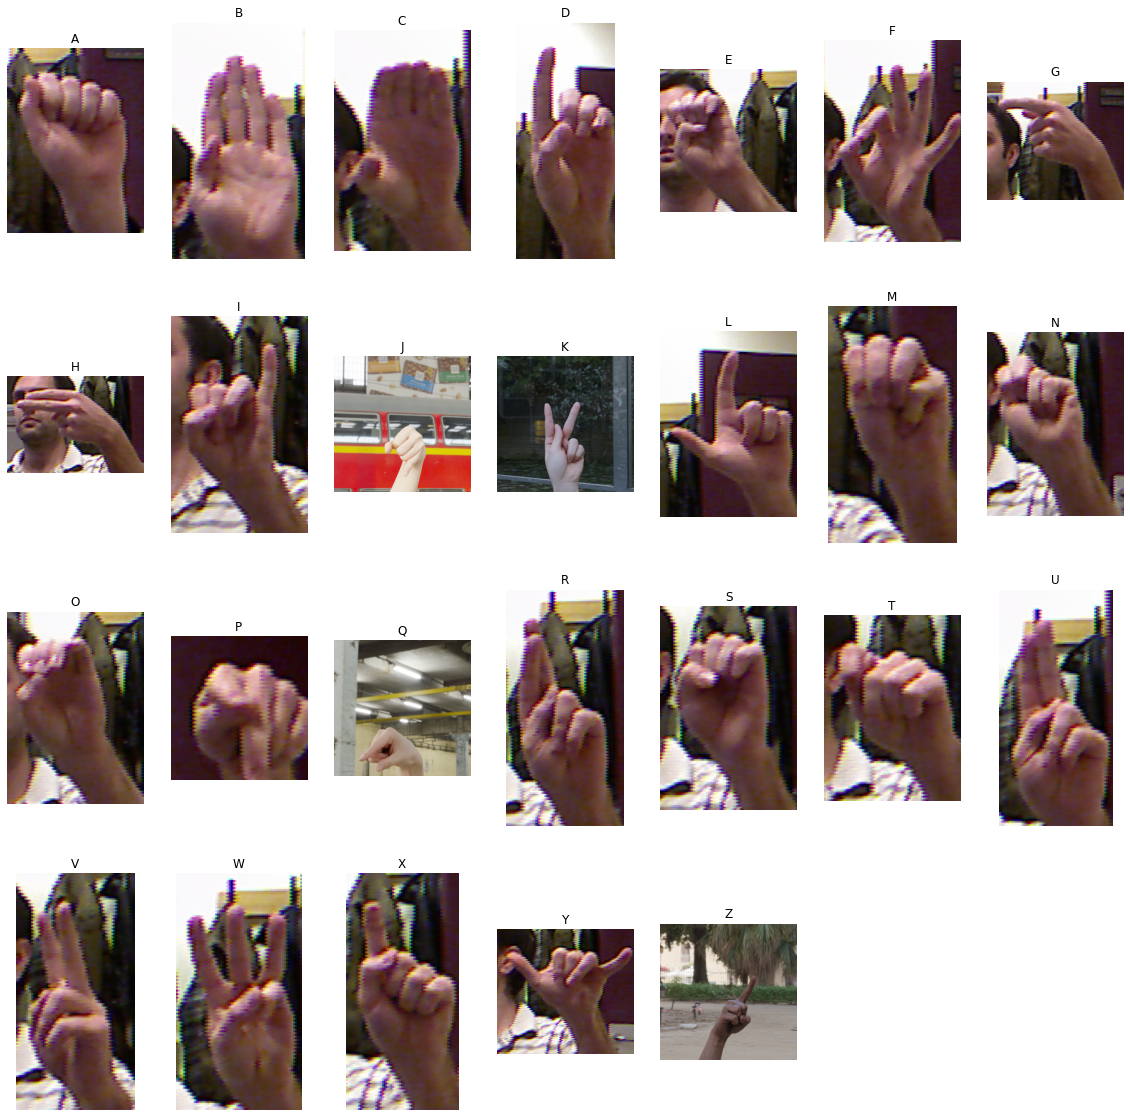

In [ ]:
from PIL import Image
%matplotlib inline
plt.figure(figsize=(20, 20))
for i, (k, v) in enumerate(data.items()):
    img = Image.open(v)
    plt.subplot(4,7,i+1)
    plt.title(k)
    plt.axis('off')
    plt.imshow(img)


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The `image_batch` is a tensor of the shape `(32, 224, 224, 3)`. This is a batch of 32 images of shape `224x224x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## Configure the dataset for performance

Use buffered prefetching, so you can yield data from disk without having I/O become blocking.

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Visualize `training` results

Create plots of the loss and accuracy on the training and validation sets:

In [ ]:
def visualize(history, epochs, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(title + ' Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(title + ' Loss')
    plt.show()

## Create the model

#### Aproach 1 - Basic Tensorflow sequential model

In [ ]:
def create_nn_model():
    input = tf.keras.Input(input_shape)
    out = tf.keras.layers.Rescaling(1. / 255)(input)
    out = tf.keras.layers.Conv2D(32, 5, activation='relu')(out)
    out = tf.keras.layers.MaxPooling2D(2)(out)
    out = tf.keras.layers.Conv2D(64, 3, activation='relu')(out)
    out = tf.keras.layers.MaxPooling2D(2)(out)
    out = tf.keras.layers.Conv2D(64, 3, activation='relu')(out)
    out = tf.keras.layers.MaxPooling2D(2)(out)
    out = tf.keras.layers.Flatten()(out)
    out = tf.keras.layers.Dense(64, activation='relu')(out)
    out = tf.keras.layers.Dense(128, activation='relu')(out)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(out)
    return keras.Model(input, out)


In [ ]:
# Aproach 1 - Basic Tensorflow sequential model
#model = create_nn_model()
model = tf.keras.models.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width ,3)),
    MaxPooling2D(2),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(
      optimizer=tf.keras.optimizers.SGD(0.001),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=['accuracy'],
  )

metrics1 = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 26, 26, 64)      

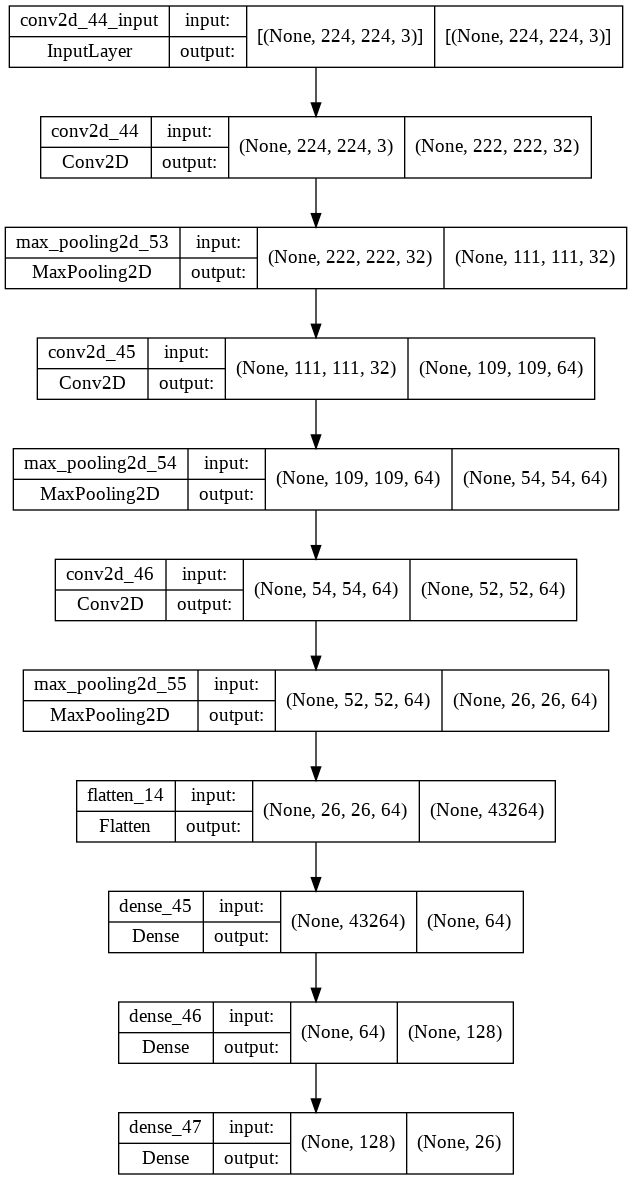

In [ ]:
pd.options.display.max_rows = 4000
tf.keras.utils.plot_model(model,'model.png', show_shapes=True)

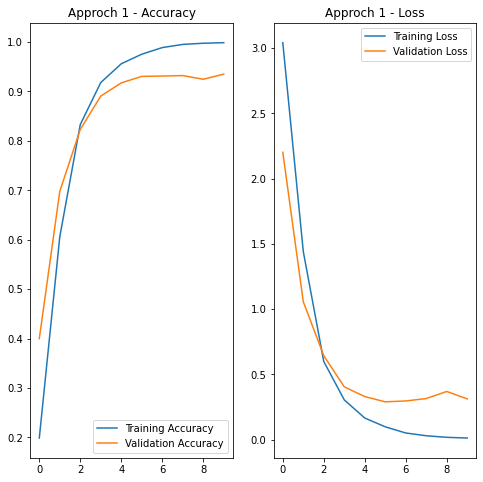

In [ ]:
visualize(metrics1, num_epochs, "Approch 1 -")

### Approch 2 - Advanced tensorflow model

#### Train model

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = octo_asl_model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, octo_asl_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, octo_asl_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

#### Test Model

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = octo_asl_model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
# Approch 2 - Advanced tensorflow model
class OctoAslModel(Model):
    def __init__(self):
        super(OctoAslModel, self).__init__()
        self.rescale = Rescaling(1. / 255)
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.maxpool2d1 = MaxPooling2D(2)
        self.conv2 = Conv2D(64, 3, activation='relu')
        self.maxpool2d2 = MaxPooling2D(2)
        self.conv3 = Conv2D(64, 3, activation='relu')
        self.maxpool2d3 = MaxPooling2D(2)
        self.dropout = Dropout(0.2)
        self.flatten = Flatten()
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(128, activation='relu')
        self.out = Dense(num_classes, activation=None)

    def call(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = self.maxpool2d1(x)
        x = self.conv2(x)
        x = self.maxpool2d2(x)
        x = self.conv3(x)
        x = self.maxpool2d3(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)

        return self.out(x)

In [ ]:
# Create an instance of the model
octo_asl_model = OctoAslModel()
octo_asl_model.build((None,)+input_shape)
octo_asl_model.summary()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)

octo_asl_model.compile(optimizer=optimizer,loss=loss_object, metrics=['accuracy'])

#metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

EPOCHS = num_epochs
loss = []
accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

    loss.append(train_loss.result())
    accuracy.append(train_accuracy.result() * 100)
    val_loss.append(test_loss.result())
    val_accuracy.append(test_accuracy.result() * 100)

metrics2 = {
    "history" : {
        "loss": loss,
        "accuracy": accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
    }
}

Model: "octo_asl_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     multiple                  0         
                                                                 
 conv2d_47 (Conv2D)          multiple                  896       
                                                                 
 max_pooling2d_56 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          multiple                  18496     
                                                                 
 max_pooling2d_57 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          multiple             

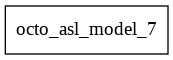

In [ ]:
pd.options.display.max_rows = 4000
tf.keras.utils.plot_model(octo_asl_model,'octo_asl_model.png', show_shapes=True)

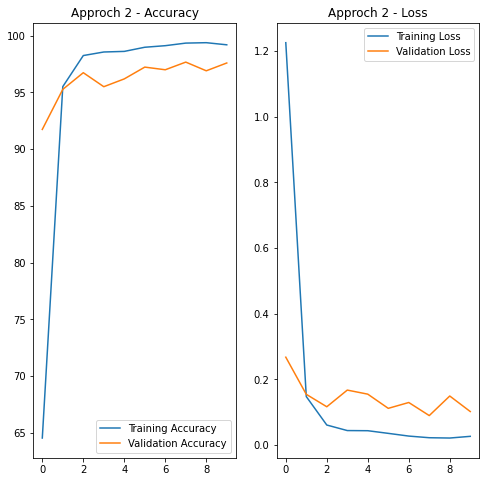

In [ ]:
acc = metrics2['history']['accuracy']
val_acc = metrics2['history']['val_accuracy']

loss = metrics2['history']['loss']
val_loss = metrics2['history']['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Approch 2 - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Approch 2 - Loss')
plt.show()

### Approch 3 - Transfer learning using ResNet50V2

In [ ]:
# Approch 3 - Transfer learning using ResNet50V2
input = tf.keras.Input(input_shape)
resnet = tf.keras.applications.ResNet50V2(include_top=False,
                                          input_shape=input_shape,
                                          input_tensor=input,
                                          pooling="avg")

# Add ResNet50V2 specific preprocessing method into the model.
preprocessed = tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet_v2.preprocess_input(x))(input)
out = resnet(preprocessed)
out = tf.keras.layers.Dense(num_classes, activation=None)(out)
asl_resnet_model = keras.Model(input, out)

asl_resnet_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

asl_resnet_model.summary()

resnet_model_path = os.path.join(".", "Octo_ASL_ResNet_model", str(1))
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=5,
                                                restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint(resnet_model_path, 'val_accuracy',
                                                  save_best_only=True)
               ]
metrics3 = asl_resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=num_epochs,
  callbacks=callbacks
)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_44 (Dense)            (None, 26)                53274     
                                                                 
Total params: 23,618,074
Trainable params: 23,572,634
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
770/770 [==============================] - 188s 233ms/step - loss: 0.3600 - accuracy: 0.8937 - val_loss: 0.1514 - val_accuracy: 0.9524
Epoch 2/10
770/770 [========

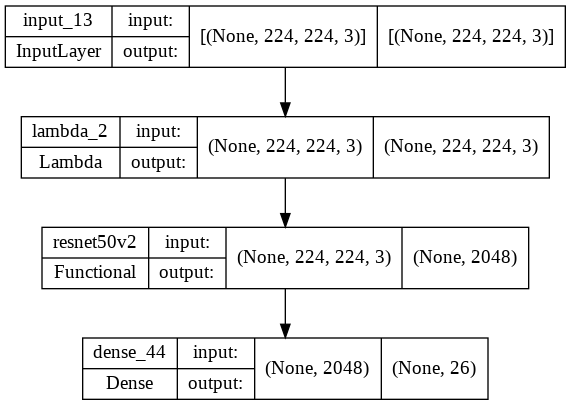

In [ ]:
tf.keras.utils.plot_model(asl_resnet_model,'resnet_model_path.png', show_shapes=True)

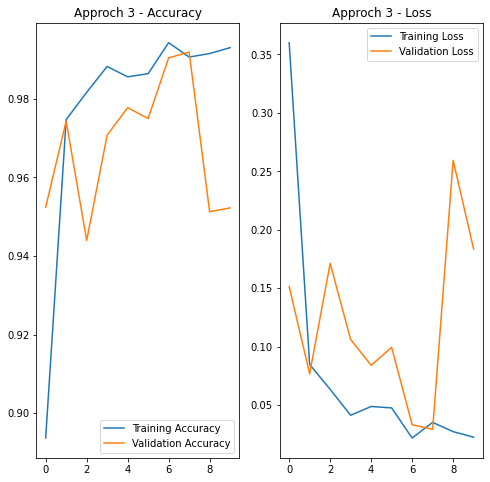

In [ ]:
visualize(metrics3, num_epochs, "Approch 3 -")

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/asl_model')
octo_asl_model.save('saved_model/octo_asl_model')
asl_resnet_model.save('saved_model/asl_resnet_model')

## Model Test results



In [ ]:
results1 = model.evaluate(test_ds, verbose=1)
print("basic_model      --> test loss, test acc:", results1)

results2 = octo_asl_model.evaluate(test_ds, verbose=1)
print("octo_asl_model   --> test loss, test acc:", results2)

results3 = asl_resnet_model.evaluate(test_ds, verbose=1)
print("asl_resnet_model --> test loss, test acc:", results3)

241/241 [==============================] - 25s 104ms/step - loss: 0.3029 - accuracy: 0.9365
basic_model      --> test loss, test acc: [0.3029477894306183, 0.9365182518959045]
241/241 [==============================] - 26s 108ms/step - loss: 0.1025 - accuracy: 0.9759
octo_asl_model   --> test loss, test acc: [0.10254591703414917, 0.9758535623550415]
241/241 [==============================] - 33s 138ms/step - loss: 0.1432 - accuracy: 0.9587
asl_resnet_model --> test loss, test acc: [0.1432432234287262, 0.958717405796051]


## Predict on new data

In [ ]:
def predict_new_image(test_img_path, approch):
    img = tf.keras.preprocessing.image.load_img(test_img_path)

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array = tf.image.resize(img_array, [img_height, img_width], method='nearest')
    predictions = None
    if approch == 1:
        predictions = model.predict(img_array)
    elif approch == 2:
        predictions = octo_asl_model.predict(img_array)
    else:
        predictions = asl_resnet_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "Approch "+ str(approch) + ", This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score) if approch != 1 else 100 * np.max(score) * 10)
    )

In [ ]:
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_O.png", 1)
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_O.png", 2)
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_O.png", 3)

Approch 1, This image most likely belongs to O with a 98.07 percent confidence.
Approch 2, This image most likely belongs to O with a 100.00 percent confidence.
Approch 3, This image most likely belongs to O with a 100.00 percent confidence.


In [ ]:
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_E.png", 1)
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_E.png", 2)
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_E.png", 3)

Approch 1, This image most likely belongs to E with a 97.97 percent confidence.
Approch 2, This image most likely belongs to E with a 100.00 percent confidence.
Approch 3, This image most likely belongs to E with a 96.57 percent confidence.


In [ ]:
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/A_test.jpg", 1)
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/A_test.jpg", 2)
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/A_test.jpg", 3)

Approch 1, This image most likely belongs to P with a 81.73 percent confidence.
Approch 2, This image most likely belongs to C with a 64.13 percent confidence.
Approch 3, This image most likely belongs to C with a 18.44 percent confidence.


In [ ]:
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_A.png", 1)
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_A.png", 2)
predict_new_image("/content/drive/MyDrive/octo-ai/ASL/test_A.png", 3)

Approch 1, This image most likely belongs to A with a 98.05 percent confidence.
Approch 2, This image most likely belongs to A with a 100.00 percent confidence.
Approch 3, This image most likely belongs to A with a 100.00 percent confidence.


## TensorBoard

### tensorboard metrics

## Utilities

### Adding Noise to the data

In [ ]:
# add noise to train_photos (non-augmented photos)
# could alternatively add noise to all photos including the augmented images in total_dataset
import random
from skimage.util import random_noise
from google.colab.patches import cv2_imshow

# noise is added to every nth image of the dataset
n = 10

def add_random_noise(image, noise_mode):
  # Add salt-and-pepper noise to the image.
  float_img = image.astype(np.float32)/255.0
  noise_img = random_noise(float_img, mode=noise_mode)#, amount=0.1)
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  return noise_img

noise_modes = ['gaussian','localvar','poisson','salt','pepper','s&p','speckle']
i=1
j = 0
noise_img_arr = []
noise_img_label_arr = []

#for image in train_photos[::n]:
for image in range(0, len(train_photos)-1, n):
  #for mode in noise_modes:
  train_photos[image] = add_random_noise(train_photos[image].astype('uint8'),noise_modes[j])
  noise_img_arr.append(train_photos[image])
  noisy_label = train_labels[image]
  noise_img_label_arr.append(noisy_label)
  i = i+1
  j = j+1
  if j >= len(noise_modes):
    j = 0

### Data augmentation

In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### another way
from keras.preprocessing.image import ImageDataGenerator


augmentation1 = ImageDataGenerator(rotation_range=10, horizontal_flip=True)
augmentation2 = ImageDataGenerator(rotation_range=15, zoom_range=0.1, horizontal_flip=True, width_shift_range=0.15, height_shift_range=0.15, brightness_range=(0.1, 1.0), fill_mode= "nearest", shear_range=0.15)
augmentation3 = ImageDataGenerator(rotation_range=10, horizontal_flip=False, brightness_range=(0.1,1.0), fill_mode= "nearest")

train_generator = augmentation1.flow_from_directory(train_dataset_dir, target_size=image_shape, shuffle=False, batch_size=batch_size)


Visualize a few augmented examples by applying data augmentation to the same image several times:

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### To convert dataset into .npy format

In [ ]:
import pathlib
import random
import shutil
import os

# Preparing dataset (SIZE 1000 approx. for each class)
COUNT = 1000
CWD = os.getcwd()
src_dir = CWD + '/dataset_full'
dst_dir = CWD + '/aslset'
if os.path.isdir(dst_dir):
    shutil.rmtree(dst_dir)
for root, dirs, files in os.walk(src_dir, topdown=False):
    for dir in dirs:
        create_dir = dst_dir + '/'+ dir
        pathlib.Path(create_dir).mkdir(parents=True, exist_ok=True)
        for root, dirs, files in os.walk(src_dir + '/'+ dir, topdown=False):
            temp_count = 0
            # for first COUNT number of images
            #for file in files:
            # for random COUNT numbr of images
            try:
                for file in random.sample(files, COUNT):
                    if temp_count >= COUNT:
                        break
                    shutil.copy(src_dir + '/'+ dir + '/' + file, create_dir)
                    temp_count = temp_count + 1
            except ValueError:
                print('sample is limited in directory ' + dir)
                for file in files:
                    if temp_count >= COUNT:
                        break
                    shutil.copy(src_dir + '/'+ dir + '/' + file, create_dir)
                    temp_count = temp_count + 1
            print('working on directory= ' + str(dir) + ';     images copied= '+ str(temp_count))



In [ ]:
'''
Converts all images in a directory to '.npy' format.
'''
def load_dataset(src_dir):
    X_dataset=[]
    Y_dataset=[]
    # Append images to a list
    for root, dirs, files in os.walk(src_dir, topdown=False):
        for d in dirs:
            for root, dirs, files in os.walk(src_dir + '/'+ d, topdown=False):
                temp_class_list = []
                for file in files:
                    if os.path.isfile(src_dir + '/'+ d + '/' + file):
                        # load the image via load_img function
                        #img = tf.keras.utils.load_img(src_dir + '/'+ d + '/' + file, color_mode = "grayscale")
                        img = tf.keras.utils.load_img(src_dir + '/'+ d + '/' + file)

                        # details about the image printed below
                        #print(type(img))
                        #print(img.format)
                        #print(img.mode)
                        #print(img.size)

                        # convert the given image into  numpy array
                        img_numpy_array = tf.keras.utils.img_to_array(img)
                        img_numpy_array = (img_numpy_array / 255.).astype(np.float32)
                        # Data augmentation
                        img_numpy_array = tf.image.central_crop(img_numpy_array, 0.7)
                        img_numpy_array = tf.image.resize(img_numpy_array, [IMAGE_HEIGHT, IMAGE_WIDTH], method='nearest')
                        #output.shape  #=> (5, 24, 24, 3)
                        #print("Image is converted and NumPy array information :")
                        #print(type(img_numpy_array))
                        #print("type:", img_numpy_array.dtype)
                        #print("shape:", img_numpy_array.shape)
                        #temp_class_list.append(img_numpy_array)
                        X_dataset.append(img_numpy_array)
                        Y_dataset.append(d)
                #X_dataset.append(temp_class_list)


    x = np.asarray(X_dataset, dtype=np.float32)
    y = np.asarray(Y_dataset, dtype=object)
    return x, y


#if __name__ == "__main__":
    # Path to image directory
CWD = os.getcwd()
src_dir = CWD + "/aslset/"
X, Y = load_dataset(src_dir=src_dir)
print(X.shape)
print(Y)

# Convert and save the list of images in '.npy' format
np.save("X_asl_128.npy", X)
np.save("Y_asl_128.npy", Y)

### To resize images in the dataset

In [ ]:
### resize images
def process_image(x):
    #x = tf.convert_to_tensor(x, dtype=tf.uint8)
    return tf.image.resize(x, [img_height, img_width], method='nearest')

def process_list(X):
    L = [process_image(x) for x in X]
    return np.asarray(L, dtype=np.float32)
X= process_list(X)
print("X shape=", X.shape)